In [34]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sqlalchemy import create_engine, text
import urllib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
BASE_DIR = "Vault Health & Reserve Monitoring"
folders = ["data", "notebooks", "models", "scripts", "api", "output"]
for folder in folders:
    os.makedirs(os.path.join(BASE_DIR, folder), exist_ok=True)
print("Folders created successfully!")

Folders created successfully!


In [37]:
#Generate Synthetic Data
num_vaults = 5
num_partners = 3
num_days = 60

vault_ids = [f"V{100+i}" for i in range(num_vaults)]
partner_ids = [f"P{10+i}" for i in range(num_partners)]

data = []
for vault in vault_ids:
    for partner in partner_ids:
        for i in range(num_days):
            date = datetime.now() - timedelta(days=i)
            redemption = np.random.randint(1000, 5000)
            refill = np.random.randint(0, 3000)
            data.append([vault, partner, date.date(), redemption, refill])

df = pd.DataFrame(data, columns=["vault_id", "partner_id", "date", "redemption_amount", "refill_amount"])

# Save CSV
csv_path = os.path.join(BASE_DIR, "data", "vault_transactions.csv")
df.to_csv(csv_path, index=False)
print(f"Sample data created at: {csv_path}")


Sample data created at: Vault Health & Reserve Monitoring\data\vault_transactions.csv


In [38]:
#MySQL Connection & Table Creation
# ===============================
# MySQL credentials
user = "root"
password = "Hrushi@20"  # replace with your password
password = urllib.parse.quote_plus(password)  # encode @
host = "localhost"
port = "3306"
db_name = "vault_monitoring"

# Connect to MySQL server
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}")
conn = engine.connect()
conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {db_name}"))
conn.close()
print(f"Database '{db_name}' ensured!")

# Connect to database
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db_name}")
conn = engine.connect()

# Create table
create_table_query = """
CREATE TABLE IF NOT EXISTS vault_transactions (
    id INT AUTO_INCREMENT PRIMARY KEY,
    vault_id VARCHAR(10),
    partner_id VARCHAR(10),
    date DATE,
    redemption_amount INT,
    refill_amount INT
)
"""
conn.execute(text(create_table_query))
conn.close()
print("Table 'vault_transactions' created!")

Database 'vault_monitoring' ensured!
Table 'vault_transactions' created!


In [27]:
from sqlalchemy import create_engine, text
import urllib

# MySQL credentials
user = "root"
password = "Hrushi@20"
password = urllib.parse.quote_plus(password)  # encode @ symbol
host = "localhost"
port = "3306"
db_name = "vault_monitoring"

# Connect to MySQL server (without specifying database yet)
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}")
conn = engine.connect()

# Create database using text()
conn.execute(text(f"CREATE DATABASE IF NOT EXISTS {db_name}"))
conn.close()

# Connect to the newly created database
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db_name}")
conn = engine.connect()

# Create table
create_table_query = """
CREATE TABLE IF NOT EXISTS vault_transactions (
    id INT AUTO_INCREMENT PRIMARY KEY,
    vault_id VARCHAR(10),
    partner_id VARCHAR(10),
    date DATE,
    redemption_amount INT,
    refill_amount INT
)
"""
conn.execute(text(create_table_query))
conn.close()

print("Database and table created successfully!")


Database and table created successfully!


In [39]:
#Load Data into MySQL

df.to_sql("vault_transactions", con=engine, if_exists="replace", index=False)
print("Data loaded into MySQL successfully!")


Data loaded into MySQL successfully!


In [40]:
#Preprocess Data for ML
df['net_change'] = df['refill_amount'] - df['redemption_amount']

X = df[['refill_amount', 'net_change']]
y = df['redemption_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Data preprocessing done!")


Data preprocessing done!


In [41]:
#Train Redemption Prediction Model

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
preds = model.predict(X_test)
mse = mean_squared_error(y_test, preds)
print(f"Redemption Prediction MSE: {mse}")

# Save model
model_path = os.path.join(BASE_DIR, "models", "redemption_model.pkl")
joblib.dump(model, model_path)
print(f"Model saved at: {model_path}")


Redemption Prediction MSE: 3649.6867522222205
Model saved at: Vault Health & Reserve Monitoring\models\redemption_model.pkl


In [42]:
#Load Model & Make Prediction
# Load model
model_loaded = joblib.load(model_path)

# Example prediction
example = pd.DataFrame([{'refill_amount': 1500, 'net_change': -500}])
pred_example = model_loaded.predict(example)[0]
print(f"Predicted Redemption Amount: {pred_example}")


Predicted Redemption Amount: 1989.4


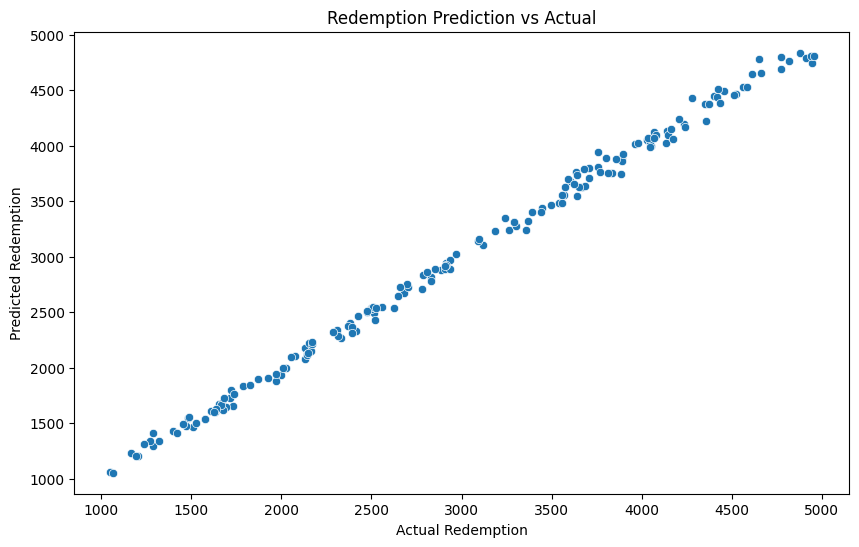

In [43]:
# Visualization

df_test = X_test.copy()
df_test['actual'] = y_test
df_test['predicted'] = preds

plt.figure(figsize=(10,6))
sns.scatterplot(x='actual', y='predicted', data=df_test)
plt.xlabel("Actual Redemption")
plt.ylabel("Predicted Redemption")
plt.title("Redemption Prediction vs Actual")
plt.show()

15:06:44 - cmdstanpy - INFO - Chain [1] start processing
15:06:44 - cmdstanpy - INFO - Chain [1] done processing
15:06:44 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:45 - cmdstanpy - INFO - Chain [1] done processing
15:06:45 - cmdstanpy - INFO - Chain [1] start processing
15:06:46 - cmdstanpy - INFO - Chain [1] done processing


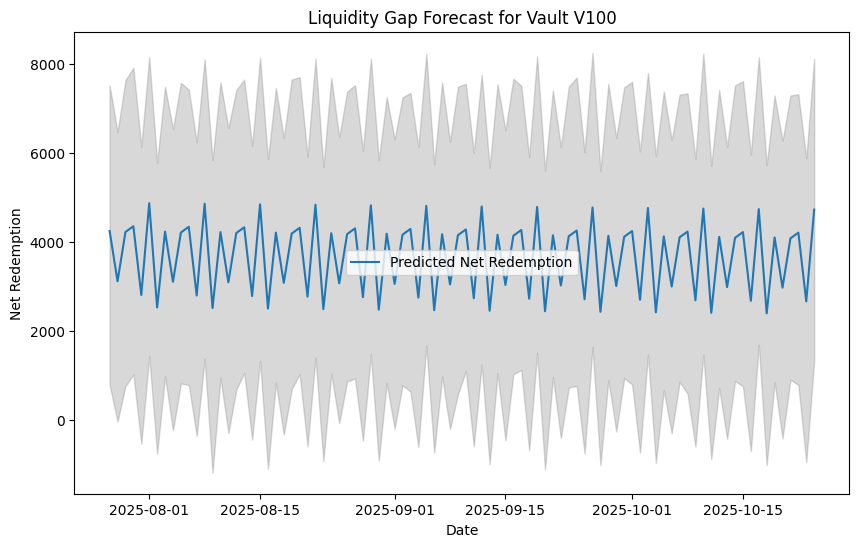

In [46]:

# Liquidity Gap Prediction
from prophet import Prophet
import matplotlib.pyplot as plt

vault_forecasts = {}

for vault in df['vault_id'].unique():
    vault_data = df[df['vault_id'] == vault].copy()
    vault_data['net_redemption'] = vault_data['redemption_amount'] - vault_data['refill_amount']
    daily_data = vault_data.groupby('date')['net_redemption'].sum().reset_index()
    daily_data = daily_data.rename(columns={'date': 'ds', 'net_redemption': 'y'})
    
    # Correct Prophet initialization
    model_prophet = Prophet(daily_seasonality=True)
    model_prophet.fit(daily_data)
    
    future = model_prophet.make_future_dataframe(periods=30)
    forecast = model_prophet.predict(future)
    vault_forecasts[vault] = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Example plot
vault_example = df['vault_id'].unique()[0]
forecast_example = vault_forecasts[vault_example]

plt.figure(figsize=(10,6))
plt.plot(forecast_example['ds'], forecast_example['yhat'], label='Predicted Net Redemption')
plt.fill_between(forecast_example['ds'], forecast_example['yhat_lower'], forecast_example['yhat_upper'], color='gray', alpha=0.3)
plt.title(f'Liquidity Gap Forecast for Vault {vault_example}')
plt.xlabel('Date')
plt.ylabel('Net Redemption')
plt.legend()
plt.show()


Partner vault performance scores:


,partner_id,total_redemption,total_refill,avg_redemption,redemption_std,performance_score
0,P10,911841,441153,3039.470000,1188.468477,0.00
1,P11,847453,495598,2824.843333,1113.270507,-0.01
2,P12,874406,467129,2914.686667,1137.797477,0.00


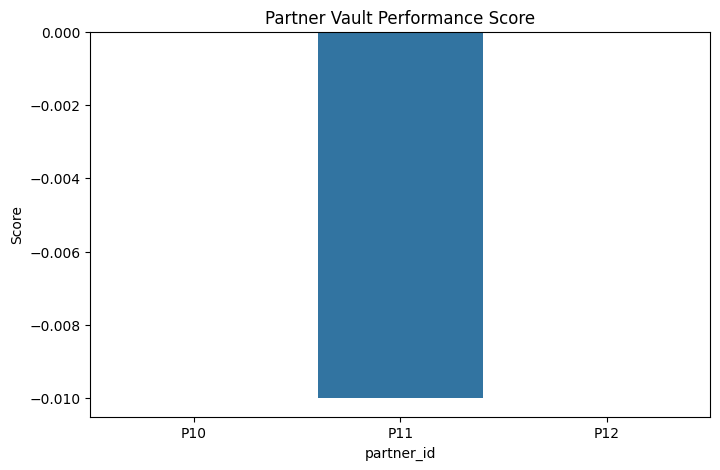

In [47]:
# Cell 10: Partner Vault Performance Scoring

# Compute simple metrics per partner
partner_scores = df.groupby('partner_id').agg(
    total_redemption=('redemption_amount', 'sum'),
    total_refill=('refill_amount', 'sum'),
    avg_redemption=('redemption_amount', 'mean'),
    redemption_std=('redemption_amount', 'std')
).reset_index()

# Simple scoring formula:
# Higher avg redemption = good
# Higher std deviation = risk
partner_scores['performance_score'] = (partner_scores['avg_redemption'] / partner_scores['avg_redemption'].max()) - (partner_scores['redemption_std'] / partner_scores['redemption_std'].max())
partner_scores['performance_score'] = partner_scores['performance_score'].round(2)

print("Partner vault performance scores:")
display(partner_scores)

# Visualization
plt.figure(figsize=(8,5))
sns.barplot(x='partner_id', y='performance_score', data=partner_scores)
plt.title("Partner Vault Performance Score")
plt.ylabel("Score")
plt.show()
